# Multivariate Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data and Model Import

In [2]:
data = pd.read_csv('data/data.csv', low_memory=False)

In [3]:
data['Coastal?'] = data['Coastal?'].fillna(False).astype(int)

mapping_dict = {'Arid': 0, 'Snow': 1, 'Temperate': 2, 'Tropical': 3}
data['Climate Zone'] = data['Climate Zone'].map(mapping_dict)

In [4]:
features = ['Built Fraction', 'Grass Fraction', 'Tree Fraction', 
            'Built Albedo', 'Grass Albedo', 'Tree Albedo', 'Elevation',
            'Coastal?', 'Climate Zone']

In [5]:
labels = ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night']

## Helper Functions

In [6]:
def get_data(label):
    Xy = data[features+[label]].dropna().copy()
    X  = Xy.copy()[features]
    y  = Xy.copy()[label]

    return X, y

### Feature Importance
We provide feature importance of the linear regression coefficients by standardizing the features.

In [7]:
def transform(X):
    X_transform = X.copy()
    for feature in features:
        X_transform[feature] = StandardScaler().fit_transform(np.array(X_transform[feature]).reshape(-1, 1))
        return X_transform

In [8]:
def get_model(X, y):
    X       = sm.add_constant(X)
    model   = sm.OLS(y, np.asarray(X))
    results = model.fit()
    
    return model, results

In [9]:
def save_results(results, label):
    summary = pd.DataFrame({'Features': ['Constant']+features, 'Coefficients': np.asarray(results.params), 
                           'LB': np.asarray(results.conf_int()[0]), 'UB': np.asarray(results.conf_int()[1]), 
                           'pval': np.asarray(results.pvalues)})
    summary = summary.round(4)
    summary.to_csv('tables/linear_regression/{}.csv'.format(label),index=False)
    return

## Multivariate Linear Regression

- Compute results summary for each label
- Create a graph of standardized effect and weighted effect for each label 

### Standard Model Results

In [10]:
for label in labels:
    X, y = get_data(label)
    model, results = get_model(X, y)
    save_results(results, label)
    print(label)
    print('R2: {:.3f}'.format(results.rsquared))
    print('RMSE: {:.3f}'.format(sqrt(results.mse_total)))

CUHI Day
R2: 0.314
RMSE: 0.693
CUHI Night
R2: 0.464
RMSE: 0.550
SUHI Day
R2: 0.468
RMSE: 2.988
SUHI Night
R2: 0.356
RMSE: 0.974


### Feature Importance for Linear Regression
Here, standardized provides us with comparable coefficients on the same scale so that we can glean variable importance from the linear model.

In [11]:
def weighted_effect(X_tranform, feat_imp):
    weighted_X = X_tranform.copy()
    weights    = feat_imp['Coefficients'].to_numpy()
    for i in range(len(features)):
        feature = features[i]
        weight  = weights[i] 
        weighted_X[feature] = weighted_X[feature] * weight
    return weighted_X

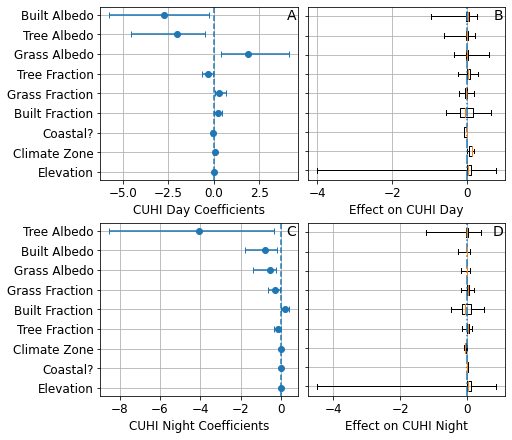

In [17]:
targets = ['CUHI Day', 'CUHI Night']
col1, col2 = ['A', 'C'], ['B', 'D']
font = {'size': 12}
matplotlib.rc('font', **font)
nrows, ncols = 2, 2
#fig, ax = plt.subplots(nrows, ncols, figsize=(5,8), constrained_layout=True)
fig, ax = plt.subplots(nrows, ncols, figsize=(7,6), constrained_layout=True)

for i in range(nrows):
    label = targets[i]
    X, y = get_data(label) # get data
    X = transform(X) # transform data
    model, results = get_model(X, y) # get model
    feat_imp = pd.DataFrame({'Features': features, 'Coefficients': np.asarray(results.params[1:]), 
                             'LB': np.asarray(results.conf_int()[0][1:]), 'UB': np.asarray(results.conf_int()[1][1:])})
    weighted_X = weighted_effect(X, feat_imp)
    feat_imp_sorted = feat_imp.sort_values(by='Coefficients', key=abs, ascending=True)
    
    # Uneven confidence intervals (errors)
    lower_errors = feat_imp_sorted['LB'].to_numpy()
    upper_errors = feat_imp_sorted['UB'].to_numpy()

    # Asymmetric error values for plotting
    errors = [np.abs(lower_errors), np.abs(upper_errors)]

    # Create the plot with error bars
    ax[i][0].errorbar(np.asarray(feat_imp_sorted['Coefficients']), np.asarray(feat_imp_sorted['Features']), xerr=errors, fmt='o', capsize=3)
    ax[i][0].set_xlabel('{} Coefficients'.format(targets[i]))
    ax[i][0].axvline(0, linestyle='dashed')
    ax[i][0].grid(True)
    ax[i][0].text(0.99, 0.99, col1[i], ha='right', va='top', transform=ax[i][0].transAxes, fontsize=14)

    ax[i][1].boxplot([weighted_X[feature].to_numpy() for feature in feat_imp_sorted['Features'].to_list()], vert=False, showfliers=False, whis=(0,100))
    ax[i][1].axvline(0, linestyle='dashdot')
    ax[i][1].set_xlabel('Effect on {}'.format(targets[i]))
    ax[i][1].tick_params(labelleft=False) 
    ax[i][1].grid(True)
    ax[i][1].text(0.99, 0.99, col2[i], ha='right', va='top', transform=ax[i][1].transAxes, fontsize=14)

plt.savefig('graphs/variable_importance/linear_model/linear_feature_importance_cuhi.svg', bbox_inches='tight', dpi=1000)
plt.savefig('graphs/variable_importance/linear_model/300dpi/linear_feature_importance_cuhi.svg', bbox_inches='tight', dpi=300)
plt.savefig('graphs/variable_importance/linear_model/jpg/linear_feature_importance_cuhi.jpg', bbox_inches='tight', dpi=1000)

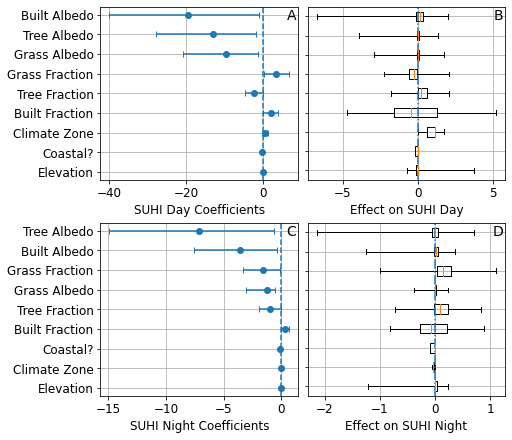

In [18]:
targets = ['SUHI Day', 'SUHI Night']
col1, col2 = ['A', 'C'], ['B', 'D']
font = {'size': 12}
matplotlib.rc('font', **font)
nrows, ncols = 2, 2
#fig, ax = plt.subplots(nrows, ncols, figsize=(5,8), constrained_layout=True)
fig, ax = plt.subplots(nrows, ncols, figsize=(7,6), constrained_layout=True)

for i in range(nrows):
    label = targets[i]
    X, y = get_data(label) # get data
    X = transform(X) # transform data
    model, results = get_model(X, y) # get model
    feat_imp = pd.DataFrame({'Features': features, 'Coefficients': np.asarray(results.params[1:]), 
                             'LB': np.asarray(results.conf_int()[0][1:]), 'UB': np.asarray(results.conf_int()[1][1:])})
    weighted_X = weighted_effect(X, feat_imp)
    feat_imp_sorted = feat_imp.sort_values(by='Coefficients', key=abs, ascending=True)
    
    # Uneven confidence intervals (errors)
    lower_errors = feat_imp_sorted['LB'].to_numpy()
    upper_errors = feat_imp_sorted['UB'].to_numpy()

    # Asymmetric error values for plotting
    errors = [np.abs(lower_errors), np.abs(upper_errors)]

    # Create the plot with error bars
    ax[i][0].errorbar(np.asarray(feat_imp_sorted['Coefficients']), np.asarray(feat_imp_sorted['Features']), xerr=errors, fmt='o', capsize=3)
    ax[i][0].set_xlabel('{} Coefficients'.format(targets[i]))
    ax[i][0].axvline(0, linestyle='dashed')
    ax[i][0].grid(True)
    ax[i][0].text(0.99, 0.99, col1[i], ha='right', va='top', transform=ax[i][0].transAxes, fontsize=14)

    ax[i][1].boxplot([weighted_X[feature].to_numpy() for feature in feat_imp_sorted['Features'].to_list()], vert=False, showfliers=False, whis=(0,100))
    ax[i][1].axvline(0, linestyle='dashdot')
    ax[i][1].set_xlabel('Effect on {}'.format(targets[i]))
    ax[i][1].tick_params(labelleft=False) 
    ax[i][1].grid(True)
    ax[i][1].text(0.99, 0.99, col2[i], ha='right', va='top', transform=ax[i][1].transAxes, fontsize=14)

plt.savefig('graphs/variable_importance/linear_model/linear_feature_importance_suhi.svg', bbox_inches='tight', dpi=1000)
plt.savefig('graphs/variable_importance/linear_model/300dpi/linear_feature_importance_suhi.svg', bbox_inches='tight', dpi=300)
plt.savefig('graphs/variable_importance/linear_model/jpg/linear_feature_importance_suhi.jpg', bbox_inches='tight', dpi=1000)